# TP1 - SPARK-Bikeshare
## - Lamara MOUZNI - Aghilas SMAIL


## Overview

This notebook will show you how to create and query a table or DataFrame that you uploaded to DBFS. [DBFS](https://docs.databricks.com/user-guide/dbfs-databricks-file-system.html) is a Databricks File System that allows you to store data for querying inside of Databricks. This notebook assumes that you have a file already inside of DBFS that you would like to read from.

This notebook is written in **Python** so the default cell type is Python. However, you can use different languages by using the `%LANGUAGE` syntax. Python, Scala, SQL, and R are all supported.

In [0]:
# File location and type
file_location = "/FileStore/tables/201801_fordgobike_tripdata.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df)

DataFrame[duration_sec: int, start_time: timestamp, end_time: timestamp, start_station_id: int, start_station_name: string, start_station_latitude: double, start_station_longitude: double, end_station_id: int, end_station_name: string, end_station_latitude: double, end_station_longitude: double, bike_id: int, user_type: string, member_birth_year: int, member_gender: string, bike_share_for_all_trip: string]

In [0]:
# Create a view or table

temp_table_name = "201801_fordgobike_tripdata_csv"

df.createOrReplaceTempView(temp_table_name)

In [0]:
%sql

-- Exécutez une commande DESCRIBE sur la vue temporaire
DESCRIBE 201801_fordgobike_tripdata_csv;

DataFrame[col_name: string, data_type: string, comment: string]

In [0]:
%sql

/* Query the created temp table in a SQL cell */

select * from `201801_fordgobike_tripdata_csv`

DataFrame[duration_sec: int, start_time: timestamp, end_time: timestamp, start_station_id: int, start_station_name: string, start_station_latitude: double, start_station_longitude: double, end_station_id: int, end_station_name: string, end_station_latitude: double, end_station_longitude: double, bike_id: int, user_type: string, member_birth_year: int, member_gender: string, bike_share_for_all_trip: string]

In [0]:
# With this registered as a temp view, it will only be available to this particular notebook. If you'd like other users to be able to query this table, you can also create a table from the DataFrame.
# Once saved, this table will persist across cluster restarts as well as allow various users across different notebooks to query this data.
# To do so, choose your table name and uncomment the bottom line.

permanent_table_name = "201801_fordgobike_tripdata_csv"

# df.write.format("parquet").saveAsTable(permanent_table_name)

In [0]:
from pyspark import SparkContext

file_location = "/FileStore/tables/201801_fordgobike_tripdata.csv"

# Charger un fichier CSV en tant que RDD
#rdd = sc.textFile(file_location)
rdd = spark.read.csv(file_location, header=True).rdd

# Afficher les 5 premières lignes de la RDD
for line in rdd.take(5):
    print(line)

Row(duration_sec='75284', start_time='2018-01-31 22:52:35.2390', end_time='2018-02-01 19:47:19.8240', start_station_id='120', start_station_name='Mission Dolores Park', start_station_latitude='37.7614205', start_station_longitude='-122.4264353', end_station_id='285', end_station_name="Webster St at O'Farrell St", end_station_latitude='37.78352083526095', end_station_longitude='-122.43115782737732', bike_id='2765', user_type='Subscriber', member_birth_year='1986', member_gender='Male', bike_share_for_all_trip='No')
Row(duration_sec='85422', start_time='2018-01-31 16:13:34.3510', end_time='2018-02-01 15:57:17.3100', start_station_id='15', start_station_name='San Francisco Ferry Building (Harry Bridges Plaza)', start_station_latitude='37.795392', start_station_longitude='-122.394203', end_station_id='15', end_station_name='San Francisco Ferry Building (Harry Bridges Plaza)', end_station_latitude='37.795392', end_station_longitude='-122.394203', bike_id='2815', user_type='Customer', member

## Scénario  2 : La différence entre le nombre de vélos entrant et sortant pour chaque station :

In [0]:
trips_start_rdd = rdd.map(lambda row: (row['start_station_id'], (row['start_station_name'], row['start_station_latitude'], row['start_station_longitude'], 1))).sortByKey()

trips_end_rdd = rdd.map(lambda row: (row['end_station_id'], 1)).sortByKey()

trips_start_counts = trips_start_rdd.reduceByKey(lambda x, y: (x[0], x[1], x[2], x[3] + y[3]))
trips_end_counts = trips_end_rdd.reduceByKey(lambda x, y: x + y)

trips_start_end_counts = trips_start_counts.join(trips_end_counts).map(lambda x: (x[0],) + x[1][0] + (x[1][1],))

# Afficher les résultats
for station_id, name,latitude,. longitude, count_start, count_end in trips_start_end_counts.collect():
    print(f"ID de la station: {station_id}, Nom de la station: {name}, Le nombre de trajets (départ): {count_start}, Le nombre de trajets (arrivée): {count_end}")

ID de la station: 10, Nom de la station: Washington St at Kearny St, Le nombre de trajets (départ): 304, Le nombre de trajets (arrivée): 381
ID de la station: 115, Nom de la station: Jackson Playground, Le nombre de trajets (départ): 312, Le nombre de trajets (arrivée): 364
ID de la station: 118, Nom de la station: Eureka Valley Recreation Center, Le nombre de trajets (départ): 224, Le nombre de trajets (arrivée): 109
ID de la station: 126, Nom de la station: Esprit Park, Le nombre de trajets (départ): 646, Le nombre de trajets (arrivée): 577
ID de la station: 127, Nom de la station: Valencia St at 21st St, Le nombre de trajets (départ): 447, Le nombre de trajets (arrivée): 421
ID de la station: 129, Nom de la station: Harrison St at 20th St, Le nombre de trajets (départ): 436, Le nombre de trajets (arrivée): 450
ID de la station: 132, Nom de la station: 24th St at Chattanooga St, Le nombre de trajets (départ): 277, Le nombre de trajets (arrivée): 108
ID de la station: 149, Nom de la s

In [0]:
!pip install folium

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-aa28adb8-5e2f-4205-b758-4171ac24658b/bin/python -m pip install --upgrade pip' command.


- Visualiser le nombre de trajets partant de chaque stations sur une carte.

In [0]:
import folium
from IPython.display import display

# Créez une carte géographique centrée sur une position GPS initiale
m = folium.Map(location=[37.7749, -122.4194], zoom_start=12)  # Coordonnées GPS de San Francisco

# Ajoutez des marqueurs pour chaque emplacement avec des informations personnalisées
for station_id, name, lat, lon, count_start, count_end in trips_start_end_counts.collect():
    radius_s = count_start/100 
    folium.CircleMarker([lat, lon], radius=radius_s, color='blue', fill=True, fill_color='blue',
                        popup=f"Station: {name}<br>Nombre de trajets (départ): {count_start}").add_to(m)

# Affichez la carte
display(m)

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<html>
<head>
 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-1.12.4.min.js"></script>
 <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@fortawesome/fontawesome-free@6.2.0/css/all.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_7980c41cb1042052f888815d8e6ed7fb {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 .leaflet-container { font-size: 1rem; }
 </style>
 
</head>
<body>
 
 
 <div class="folium-map" id="map_7980c41cb1042052f888815d8e6ed7fb" ></div>
 
</body>
<script>
 
 
 var map_7980c41cb1042052f888815d8e6ed7fb = L.map(
 "map_7980c41cb1042052f888815d8e6ed7fb",
 {
 center: [37.7749, -122.4194],
 crs: L.CRS.EPSG3857,
 zoom: 12,
 zoomControl: true,
 preferCanvas: false,
 }
 );

 

 
 
 var tile_layer_892f60f8192db47c96f81997a667fb40 = L.tileLayer(
 "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png",
 {"attribution": "Data by \u0026copy; \u003ca target=\"_blank\" href=\"http://openstreetmap.org\"\u003eOpenStreetMap\u003c/a\u003e, under \u003ca target=\"_blank\" href=\"http://www.openstreetmap.org/copyright\"\u003eODbL\u003c/a\u003e.", "detectRetina": false, "maxNativeZoom": 18, "maxZoom": 18, "minZoom": 0, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 ).addTo(map_7980c41cb1042052f888815d8e6ed7fb);
 
 
 var circle_marker_9b01874d55bb82f47e14b03c22474a12 = L.circleMarker(
 [37.79539293725452, -122.4047702550888],
 {"bubblingMouseEvents": true, "color": "blue", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "blue", "fillOpacity": 0.2, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 3.04, "stroke": true, "weight": 3}
 ).addTo(map_7980c41cb1042052f888815d8e6ed7fb);
 
 
 var popup_4074f5a55917a7414a0d5efba2186e92 = L.popup({"maxWidth": "100%"});

 
 
 var html_b240b5a97bf4ab1a24f9b00ccad3bdc4 = $(`<div id="html_b240b5a97bf4ab1a24f9b00ccad3bdc4" style="width: 100.0%; height: 100.0%;">Station: Washington St at Kearny St<br>Nombre de trajets (départ): 304</div>`)[0];
 popup_4074f5a55917a7414a0d5efba2186e92.setContent(html_b240b5a97bf4ab1a24f9b00ccad3bdc4);
 
 

 circle_marker_9b01874d55bb82f47e14b03c22474a12.bindPopup(popup_4074f5a55917a7414a0d5efba2186e92)
 ;

 
 
 
 var circle_marker_0d9d423bc5dc3f5521050759222dc9bb = L.circleMarker(
 [37.7650259, -122.3987734],
 {"bubblingMouseEvents": true, "color": "blue", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "blue", "fillOpacity": 0.2, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 3.12, "stroke": true, "weight": 3}
 ).addTo(map_7980c41cb1042052f888815d8e6ed7fb);
 
 
 var pop

- Visualiser le nombre de trajets arrivant à chaque stations sur une carte.

In [0]:
import folium
from IPython.display import display

# Créez une carte géographique centrée sur une position GPS initiale
m = folium.Map(location=[37.7749, -122.4194], zoom_start=12)  # Coordonnées GPS de San Francisco

# Ajoutez des marqueurs pour chaque emplacement avec des informations personnalisées
for station_id, name, lat, lon, count_start, count_end in trips_start_end_counts.collect():
    radius_e = count_end/100  # Utilisez value1 comme rayon du cercle
    folium.CircleMarker([lat, lon], radius=radius_e, color='red', fill=True, fill_color='red',
                        popup=f"Station: {name}<br>Nombre de trajets (arrivée): {count_end}").add_to(m)

# Affichez la carte
display(m)

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<html>
<head>
 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-1.12.4.min.js"></script>
 <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@fortawesome/fontawesome-free@6.2.0/css/all.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_eb38fc3e3534f414fdc9779e3479c1ee {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 .leaflet-container { font-size: 1rem; }
 </style>
 
</head>
<body>
 
 
 <div class="folium-map" id="map_eb38fc3e3534f414fdc9779e3479c1ee" ></div>
 
</body>
<script>
 
 
 var map_eb38fc3e3534f414fdc9779e3479c1ee = L.map(
 "map_eb38fc3e3534f414fdc9779e3479c1ee",
 {
 center: [37.7749, -122.4194],
 crs: L.CRS.EPSG3857,
 zoom: 12,
 zoomControl: true,
 preferCanvas: false,
 }
 );

 

 
 
 var tile_layer_871ddf8f2c15402fe280a727bdf2c26e = L.tileLayer(
 "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png",
 {"attribution": "Data by \u0026copy; \u003ca target=\"_blank\" href=\"http://openstreetmap.org\"\u003eOpenStreetMap\u003c/a\u003e, under \u003ca target=\"_blank\" href=\"http://www.openstreetmap.org/copyright\"\u003eODbL\u003c/a\u003e.", "detectRetina": false, "maxNativeZoom": 18, "maxZoom": 18, "minZoom": 0, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 ).addTo(map_eb38fc3e3534f414fdc9779e3479c1ee);
 
 
 var circle_marker_3cad5c5b982ae99348fcb706e75190a0 = L.circleMarker(
 [37.79539293725452, -122.4047702550888],
 {"bubblingMouseEvents": true, "color": "red", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "red", "fillOpacity": 0.2, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 3.81, "stroke": true, "weight": 3}
 ).addTo(map_eb38fc3e3534f414fdc9779e3479c1ee);
 
 
 var popup_827471901b957ed880b017ccb800c383 = L.popup({"maxWidth": "100%"});

 
 
 var html_b83d86e1fe64e48fb4da9d7bde91e488 = $(`<div id="html_b83d86e1fe64e48fb4da9d7bde91e488" style="width: 100.0%; height: 100.0%;">Station: Washington St at Kearny St<br>Nombre de trajets (arrivée): 381</div>`)[0];
 popup_827471901b957ed880b017ccb800c383.setContent(html_b83d86e1fe64e48fb4da9d7bde91e488);
 
 

 circle_marker_3cad5c5b982ae99348fcb706e75190a0.bindPopup(popup_827471901b957ed880b017ccb800c383)
 ;

 
 
 
 var circle_marker_92f86aa1bd3b37274ad730e91da9d3a4 = L.circleMarker(
 [37.7650259, -122.3987734],
 {"bubblingMouseEvents": true, "color": "red", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "red", "fillOpacity": 0.2, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 3.64, "stroke": true, "weight": 3}
 ).addTo(map_eb38fc3e3534f414fdc9779e3479c1ee);
 
 
 var popup_

- Visualiser la différence entre le nombre de trajets partant et sortant pour chaque stations sur une carte.
En vert les stations ou le le nombre de trajets entrant et plus grand.
En vert les stations ou le le nombre de trajets sortant et plus grand.

In [0]:
import folium
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.colors as mcolors

# Créez une carte géographique centrée sur une position GPS initiale avec un zoom moins élevé
m = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

# Ajoutez des cercles pour chaque emplacement avec des tailles basées sur la différence entre value1 et value2
for station_id ,station, lat, lon, count_start, count_end in trips_start_end_counts.collect():
    diff = count_end - count_start  # Calculez la différence
    radius = abs(diff)/10  # Utilisez la valeur absolue de la différence pour définir la taille du cercle

    # Définissez la couleur en fonction de la différence (rouge foncé pour négatif, vert pour positif)
    if diff < 0:
        color = mcolors.to_hex((1, 0, 0))  # Rouge
    else:
        color = mcolors.to_hex((0, 1, 0))  # Vert
    
    folium.CircleMarker([lat, lon], radius=radius, color=color, fill=True, fill_color=color,
                        popup=f"Station: {station}<br> Départs: {count_start}<br>Arrivée: {count_end}<br>Diff: {diff}").add_to(m)

# Affichez la carte dans le notebook
display(m)

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<html>
<head>
 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-1.12.4.min.js"></script>
 <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@fortawesome/fontawesome-free@6.2.0/css/all.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_f0df801f7f974a7c56768bfdd2d05cd7 {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 .leaflet-container { font-size: 1rem; }
 </style>
 
</head>
<body>
 
 
 <div class="folium-map" id="map_f0df801f7f974a7c56768bfdd2d05cd7" ></div>
 
</body>
<script>
 
 
 var map_f0df801f7f974a7c56768bfdd2d05cd7 = L.map(
 "map_f0df801f7f974a7c56768bfdd2d05cd7",
 {
 center: [37.7749, -122.4194],
 crs: L.CRS.EPSG3857,
 zoom: 12,
 zoomControl: true,
 preferCanvas: false,
 }
 );

 

 
 
 var tile_layer_5aaa817ee1b83e8775605232c7683b8c = L.tileLayer(
 "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png",
 {"attribution": "Data by \u0026copy; \u003ca target=\"_blank\" href=\"http://openstreetmap.org\"\u003eOpenStreetMap\u003c/a\u003e, under \u003ca target=\"_blank\" href=\"http://www.openstreetmap.org/copyright\"\u003eODbL\u003c/a\u003e.", "detectRetina": false, "maxNativeZoom": 18, "maxZoom": 18, "minZoom": 0, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 ).addTo(map_f0df801f7f974a7c56768bfdd2d05cd7);
 
 
 var circle_marker_0287ebe5f9317f120227ea027cbff2b4 = L.circleMarker(
 [37.79539293725452, -122.4047702550888],
 {"bubblingMouseEvents": true, "color": "#00ff00", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "#00ff00", "fillOpacity": 0.2, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 7.7, "stroke": true, "weight": 3}
 ).addTo(map_f0df801f7f974a7c56768bfdd2d05cd7);
 
 
 var popup_561aed68b9c9860c4b2690efba70f412 = L.popup({"maxWidth": "100%"});

 
 
 var html_c0f41d39ecd3d1b002193a33077754d5 = $(`<div id="html_c0f41d39ecd3d1b002193a33077754d5" style="width: 100.0%; height: 100.0%;">Station: Washington St at Kearny St<br> Départs: 304<br>Arrivée: 381<br>Diff: 77</div>`)[0];
 popup_561aed68b9c9860c4b2690efba70f412.setContent(html_c0f41d39ecd3d1b002193a33077754d5);
 
 

 circle_marker_0287ebe5f9317f120227ea027cbff2b4.bindPopup(popup_561aed68b9c9860c4b2690efba70f412)
 ;

 
 
 
 var circle_marker_5a901724dfc9e6dc10f9646b6354ed72 = L.circleMarker(
 [37.7650259, -122.3987734],
 {"bubblingMouseEvents": true, "color": "#00ff00", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "#00ff00", "fillOpacity": 0.2, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 5.2, "stroke": true, "weight": 3}
 ).addTo(map_f0df801f7f974a7c56768bfdd2d

## Scénario  2 : Nombre d'utilisateurs par heure

In [0]:
trips_hour = rdd.map(lambda row: (row['start_time'].split(' ')[1].split(':')[0], row['user_type'])).sortByKey()

hours = list(range(24))
nb_sub_hour = [0]*24
nb_users_hour = [0]*24

for hour, user in trips_hour.collect():
    if user == 'Subscriber' : nb_sub_hour[int(hour)] = nb_sub_hour[int(hour)] + 1
    else : nb_users_hour[int(hour)] = nb_users_hour[int(hour)] + 1

In [0]:
import matplotlib.pyplot as plt

# Crée un graphique d'histogramme
plt.figure(figsize=(10, 6))
plt.bar(hours, counts, color='skyblue')
plt.xlabel('Heure')
plt.ylabel('Nombre de trajets')
plt.title('Histogramme du nombre de trajets par heure')
plt.xticks(rotation=45)
plt.tight_layout()

# Affiche le graphique
plt.show()

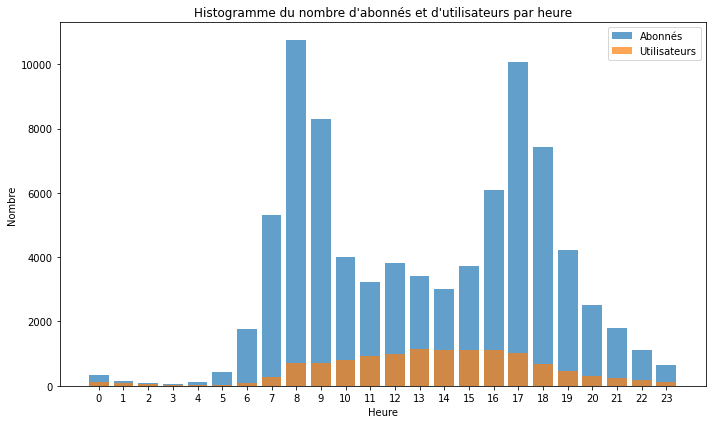

In [0]:
import matplotlib.pyplot as plt

# Supposons que vous avez des listes 'hours', 'nb_sub_hour' et 'nb_users_hour' avec les données
# Remplacez-les par vos données réelles

# Créez un graphique d'histogramme
plt.figure(figsize=(10, 6))

# Tracez l'histogramme pour le nombre d'abonnés (nb_sub_hour)
plt.bar(hours, nb_sub_hour, label='Abonnés', alpha=0.7)

# Tracez l'histogramme pour le nombre d'utilisateurs (nb_users_hour)
plt.bar(hours, nb_users_hour, label='Utilisateurs', alpha=0.7)

# Ajoutez des étiquettes d'axe et un titre
plt.xlabel('Heure')
plt.ylabel('Nombre')
plt.title('Histogramme du nombre d\'abonnés et d\'utilisateurs par heure')

# Ajoutez une légende
plt.legend()

# Personnalisez d'autres paramètres si nécessaire
plt.xticks(hours)  # Assurez-vous que les heures sont affichées sur l'axe des x
plt.tight_layout()

# Affichez le graphique
plt.show()